In [4]:
import os
import sys
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from scipy import signal as sn 
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils

In [5]:
#define some basic functions here, like xcorr and etc

@nb.njit()
def get_common_rows(specnum0,specnum1,idxstart0,idxstart1):
    nrows0,nrows1=specnum0.shape[0],specnum1.shape[0]
    maxrows=min(nrows0,nrows1)
    rownums0=np.empty(maxrows,dtype='int64')
    rownums0[:]=-1
    rownums1=rownums0.copy()
    rowidx=rownums0.copy()
    i=0;j=0;row_count=0;
    while i<nrows0 and j<nrows1:
        if (specnum0[i]-idxstart0)==(specnum1[j]-idxstart1):
            rownums0[row_count]=i
            rownums1[row_count]=j
            rowidx[row_count]=specnum0[i]-idxstart0
            i+=1
            j+=1
            row_count+=1
        elif (specnum0[i]-idxstart0)>(specnum1[j]-idxstart1):
            j+=1
        else:
            i+=1
    return row_count,rownums0,rownums1,rowidx

@nb.njit(parallel=True)
def avg_xcorr_4bit_2ant_float(pol0,pol1,specnum0,specnum1,idxstart0,idxstart1,delay=None,freqs=None):
    row_count,rownums0,rownums1,rowidx=get_common_rows(specnum0,specnum1,idxstart0,idxstart1)
    ncols=pol0.shape[1]
#     print("ncols",ncols)
    assert pol0.shape[1]==pol1.shape[1]
    xcorr=np.zeros((row_count,ncols),dtype='complex64') # in the dev_gen_phases branch
    if delay is not None:
        for i in nb.prange(row_count):
            for j in range(ncols):
                xcorr[i,j] = pol0[rownums0[i],j]*np.conj(pol1[rownums1[i],j]*np.exp(2j*np.pi*delay[rowidx[i]]*freqs[j]))
    else:
        for i in nb.prange(row_count):
            xcorr[i,:] = pol0[rownums0[i],:]*np.conj(pol1[rownums1[i],:])
    return xcorr

def get_coarse_xcorr(f1, f2, Npfb=4096):
    if len(f1.shape) == 1:
        f1 = f1.reshape(-1, 1)
    if len(f2.shape) == 1:
        f2 = f2.reshape(-1, 1)
    chans = f1.shape[1]
    Nsmall = f1.shape[0]
    wt = np.zeros(2 * Nsmall)
    wt[:Nsmall] = 1
    n_avg = np.fft.irfft(np.fft.rfft(wt) * np.conj(np.fft.rfft(wt)))
#     print(n_avg)
#     n_avg[Nsmall] = np.nan
#     print(n_avg[Nsmall-10:Nsmall+10])
    n_avg = np.tile(n_avg, chans).reshape(chans, 2*Nsmall)
#     print(n_avg.shape)
    bigf1 = np.vstack([f1, np.zeros(f1.shape, dtype=f1.dtype)])
    bigf2 = np.vstack([f2, np.zeros(f2.shape, dtype=f2.dtype)])
    bigf1 = bigf1.T.copy()
    bigf2 = bigf2.T.copy()
    bigf1f = np.fft.fft(bigf1,axis=1)
    bigf2f = np.fft.fft(bigf2,axis=1)
    xx = bigf1f * np.conj(bigf2f)
    xcorr = np.fft.ifft(xx,axis=1)
    xcorr = xcorr / n_avg
    xcorr[:,Nsmall] = np.nan
    return xcorr


<h1 style="font-size:30pt">Setup</h1>

Start with basic hard-coded stuff (to make config later)

In [27]:

T_SPECTRA = 4096/250e6


visibility_window = 1000

c_acclen = 10**6 
v_acclen = 30000

C_T_ACCLEN = c_acclen* T_SPECTRA
V_T_ACCLEN = v_acclen* T_SPECTRA

c_nchunks = int((visibility_window)/C_T_ACCLEN)
v_nchunks = int((visibility_window)/V_T_ACCLEN)


data_version = "SATDET TESTER"

if data_version == "MANUAL TESTER":

    a1_path = "/scratch/s/sievers/mohanagr/mars1_2024/baseband/"
    a2_path = "/scratch/s/sievers/mohanagr/mars2_2024/baseband/"

    global_start_time = 1721800002

    a1_coords = [79+25.031/60, -90-46.041/60, 189]  # MARS 1
    a2_coords = [79+25.033/60, -90-45.531/60, 176]  # MARS 2

elif data_version == "SATDET TESTER":

    a1_coords = [79.41718333333333, -90.76735, 189]
    a2_coords = [79.41721666666666, -90.75885, 176] #ant2
    a3_coords = [79.41541666666667, -90.77308333333333, 175] #ant3

    a1_path = "/project/s/sievers/albatros/mars/202307/baseband/stn_1_central"
    a2_path = "/project/s/sievers/albatros/mars/202307/baseband/stn_2_east" #ant2
    a3_path = "/project/s/sievers/albatros/mars/202307/baseband/stn_3_west" #ant3

    global_start_time = 1699625045
    #global_start_time = 1699788860


dir_parents = []
dir_parents.append(a1_path)
dir_parents.append(a2_path)

#a1_coords = [79+25.031/60, -90-46.041/60, 189]  # MARS 1
#a2_coords = [79+25.033/60, -90-45.531/60, 176]  # MARS 2
tle_path = outils.get_tle_file(global_start_time, "/project/s/sievers/mohanagr/OCOMM_TLES")

coords = []
coords.append(a1_coords)
coords.append(a2_coords)

In [28]:
print(T_SPECTRA * 25)

0.00040960000000000004


Mock Filtered Pass List

In [29]:
if data_version == "MANUAL TESTER":
    #from original tester coords

    filtered_pulses = [[[ 715, 1110], 28654], 
                       [[4950, 5270], 59051], 
                       [[7000, 7145], 28654], 
                       [[8615, 8970], 44387], 
                       [[10975, 11440], 59051], 
                       [[14630, 15110], 44387], 
                       [[17005, 17530], 59051], 
                       [[20650, 21180], 44387], 
                       [[22070, 22425], 25338], 
                       [[23025, 23570], 59051], 
                       [[23875, 24005], 57166], 
                       [[26665, 27205], 44387], 
                       [[27945, 28075], 33591], 
                       [[28075, 28275], 33591], 
                       [[28275, 28555], 25338], 
                       [[29040, 29580], 59051], 
                       [[29855, 30240], 57166], 
                       [[31685, 31985], 28654], 
                       [[32665, 33205], 44387], 
                       [[34005, 34085], 33591], 
                       [[34085, 34480], 33591], 
                       [[34480, 34615], 25338], 
                       [[35040, 35580], 59051], 
                       [[35875, 36370], 57166], 
                       [[37745, 38210], 28654], [[38660, 39200], 44387], [[40090, 40615], 33591], [[41045, 41590], 59051]]


elif data_version == "SATDET TESTER":

    filtered_pulses = [[[ 0,215 ], 33591 ] , 
                       [[ 505, 765 ], 28654 ] , 
                       [[ 1815, 2250 ],  57166] , 
                       [[ 4400, 4730 ], 44387 ], 
                       [[4730, 4940], 25338], 
                       [[4940, 5260], 25338], 
                       [[7840, 8350], 57166]]

#timestamp 1699788860 start

#filtered_pulses = [ [[ 1295,1395 ], 33591 ] , [[2070, 2125 ], 57166 ] , [[ 4625, 5055 ],  25338] , [[ 5055, 5165 ], 44387 ], [[7315, 7695], 33591], [[8030, 8200], 28654]]


In [30]:
pulse_idx = 0

In [31]:
print(filtered_pulses[pulse_idx][0][0])

0


In [32]:
relative_start_time = filtered_pulses[pulse_idx][0][0]
pulse_duration_sec = filtered_pulses[pulse_idx][0][1] - filtered_pulses[pulse_idx][0][0]
pulse_duration_chunks = int( pulse_duration_sec / (T_SPECTRA * c_acclen) )

time_start = global_start_time + relative_start_time
time_end = time_start + visibility_window
sat_ID = filtered_pulses[pulse_idx][1]
print(relative_start_time)
print(sat_ID)

files_a1, idx1 = butils.get_init_info(time_start, time_end, a1_path)
files_a2, idx2 = butils.get_init_info(time_start, time_end, a2_path)

channels = bdc.get_header(files_a1[0])["channels"].astype('int64')
chanstart = np.where(channels == 1834)[0][0] 
chanend = np.where(channels == 1852)[0][0]
nchans=chanend-chanstart


ant1_c = bdc.BasebandFileIterator(files_a1, 0, idx1, c_acclen, nchunks=c_nchunks, chanstart=chanstart, chanend=chanend, type='float')
ant2_c = bdc.BasebandFileIterator(files_a2, 0, idx2, c_acclen, nchunks=c_nchunks, chanstart=chanstart, chanend=chanend, type='float')

0
33591
Not reading any data
ACCLEN RECEIVED IS 1000000
took 0.209 seconds to read raw data on  /project/s/sievers/albatros/mars/202307/baseband/stn_1_central/16996/1699625038.raw
START SPECNUM IS 9461419 obj start at 9034173
ACCLEN RECEIVED IS 1000000
took 1.160 seconds to read raw data on  /project/s/sievers/albatros/mars/202307/baseband/stn_2_east/16996/1699625013.raw
START SPECNUM IS 9716462 obj start at 7763337


<h1 style="font-size:30pt">COARSE</h1>

In [33]:


p0_a1 = np.zeros((c_acclen, nchans), dtype="complex128")
p0_a2 = np.zeros((c_acclen, nchans), dtype="complex128")
p0_a2_delayed = np.zeros((c_acclen, nchans), dtype="complex128")


a1_c_start = ant1_c.spec_num_start
print(a1_c_start)
a2_c_start = ant2_c.spec_num_start
for i, (chunk1, chunk2) in enumerate(zip(ant1_c, ant2_c)):
        perc_missing_a1 = (1 - len(chunk1["specnums"]) / c_acclen) * 100
        perc_missing_a2 = (1 - len(chunk2["specnums"]) / c_acclen) * 100
        print("missing a1", perc_missing_a1, "missing a2", perc_missing_a2)
        if perc_missing_a1 > 10 or perc_missing_a2 > 10:
            a1_c_start = ant1_c.spec_num_start
            a2_c_start = ant2_c.spec_num_start
            print("skipping")
            continue
        print(chunk1["specnums"] - a1_c_start)
        outils.make_continuous(
            p0_a1, chunk1["pol0"], chunk1["specnums"] - a1_c_start
        )
        outils.make_continuous(
            p0_a2, chunk2["pol0"], chunk2["specnums"] - a2_c_start
        )
        break

    
            

9461419
print shape of my pols 998119 18
Took 0.06054282188415527 to unpack
print shape of my pols 958420 18
Took 0.05889773368835449 to unpack
missing a1 0.18810000000000215 missing a2 4.157999999999995
[     0      1      2 ... 999997 999998 999999]


In [34]:
#check this is in the right order
freqs = 250e6 * (1 - np.arange(1852, 1834, -1) / 4096)

delays = np.zeros(c_acclen)
d = outils.get_sat_delay(
                a1_coords,
                a2_coords,
                tle_path,
                time_start,
                pulse_duration_sec+1,
                sat_ID,
            )
delays = np.interp(
                np.arange(0, c_acclen) * T_SPECTRA, np.arange(0, pulse_duration_sec+1), d
            )
delays = np.asarray(delays)

outils.apply_delay(p0_a2, p0_a2_delayed, -delays, freqs)

print(p0_a2_delayed - p0_a2)

catalog #33591 epoch 2023-11-10 20:23:29 UTC
[[-1.97212539+0.02711841j -2.14719697-0.17299389j -0.40233878+2.28171801j
  ...  0.39684371+2.27914131j  2.14363726-0.16807824j
   0.03128089-1.9677085j ]
 [-1.97213199+0.02711216j -2.14720229-0.17300127j -0.40234703+2.28172186j
  ...  2.27913741-0.39683543j  2.14363187-0.16807083j
   1.96770181+0.03128716j]
 [-1.9721386 +0.02710591j -0.17300865+2.14720761j -0.40235528+2.28172571j
  ... -2.2791335 +0.39682715j -0.16806342-2.14362648j
  -1.96769513-0.03129343j]
 ...
 [ 0.74535295-0.39109844j  0.41414814+1.01360272j -1.28135947+0.38594259j
  ...  1.63114235+2.2655668j   1.37985983+2.36224319j
  -1.11480944-2.4095456j ]
 [ 0.3910995 +0.74535874j -1.01360861+0.41414808j -0.38594141-1.28136524j
  ... -2.26556945+1.63113705j -2.36224478+1.37985412j
   1.11480353+2.40954608j]
 [-0.39110056-0.74536454j -0.41414803-1.0136145j   1.28137102-0.38594024j
  ... -2.26557209+1.63113174j -1.37984841-2.36224637j
  -2.40954656+1.11479762j]]


In [35]:
xc_uncorrected = np.fft.fftshift(get_coarse_xcorr(p0_a1,p0_a2),axes=1)

xc_corrected = np.fft.fftshift(get_coarse_xcorr(p0_a1,p0_a2_delayed),axes=1)

1000000


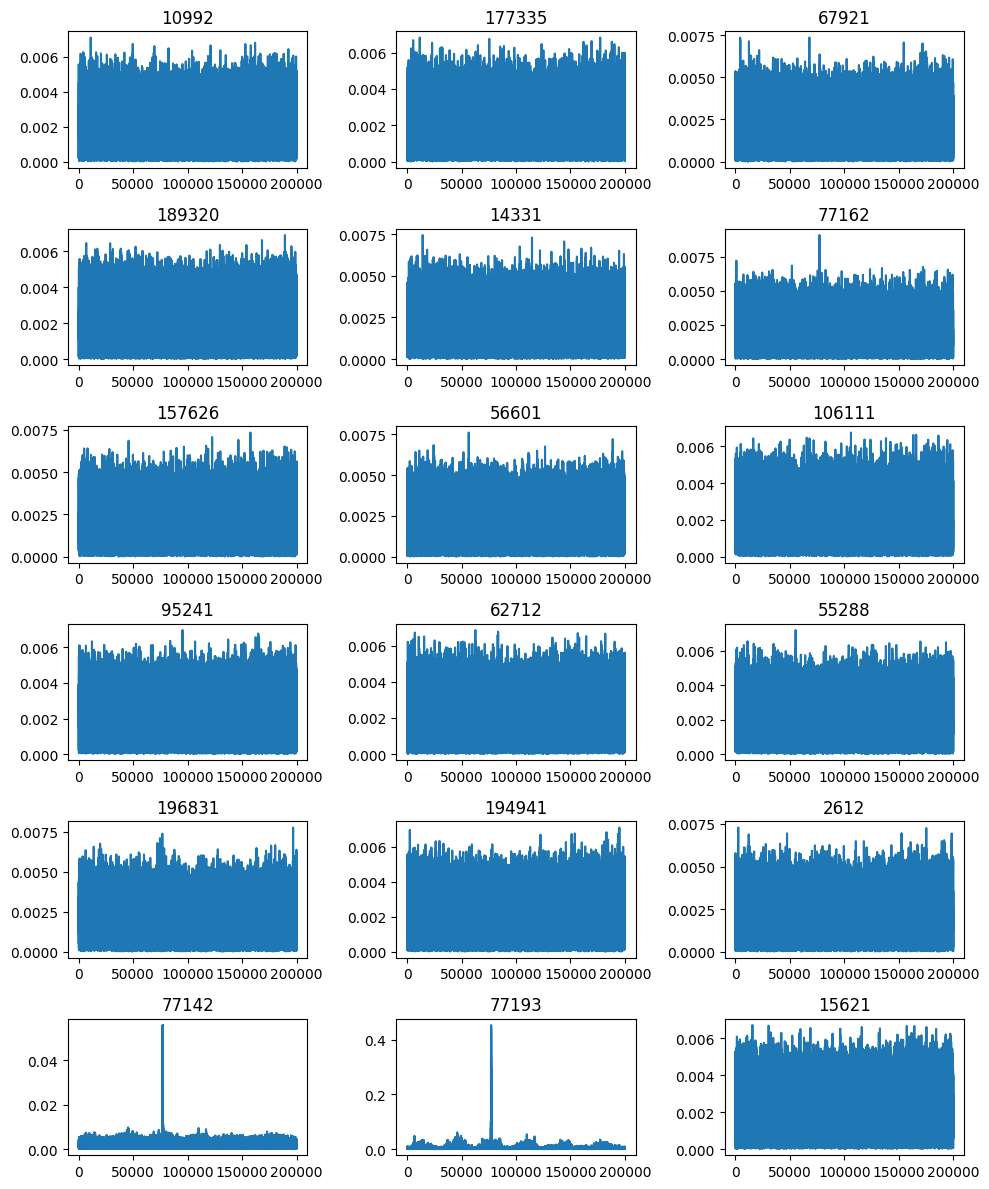

In [36]:
#UNCORRECTED

center= c_acclen
print(center)
dN= 100000
fig,ax=plt.subplots(6,3)
fig.set_size_inches(10,12)
ax=ax.flatten()
for cc in range(nchans):
    mm=np.argmax(np.abs(xc_uncorrected[cc,center-dN:center+dN]))
    ax[cc].set_title(f"{mm}")
    ax[cc].plot(np.abs(xc_uncorrected[cc,center-dN:center+dN]))
plt.tight_layout()

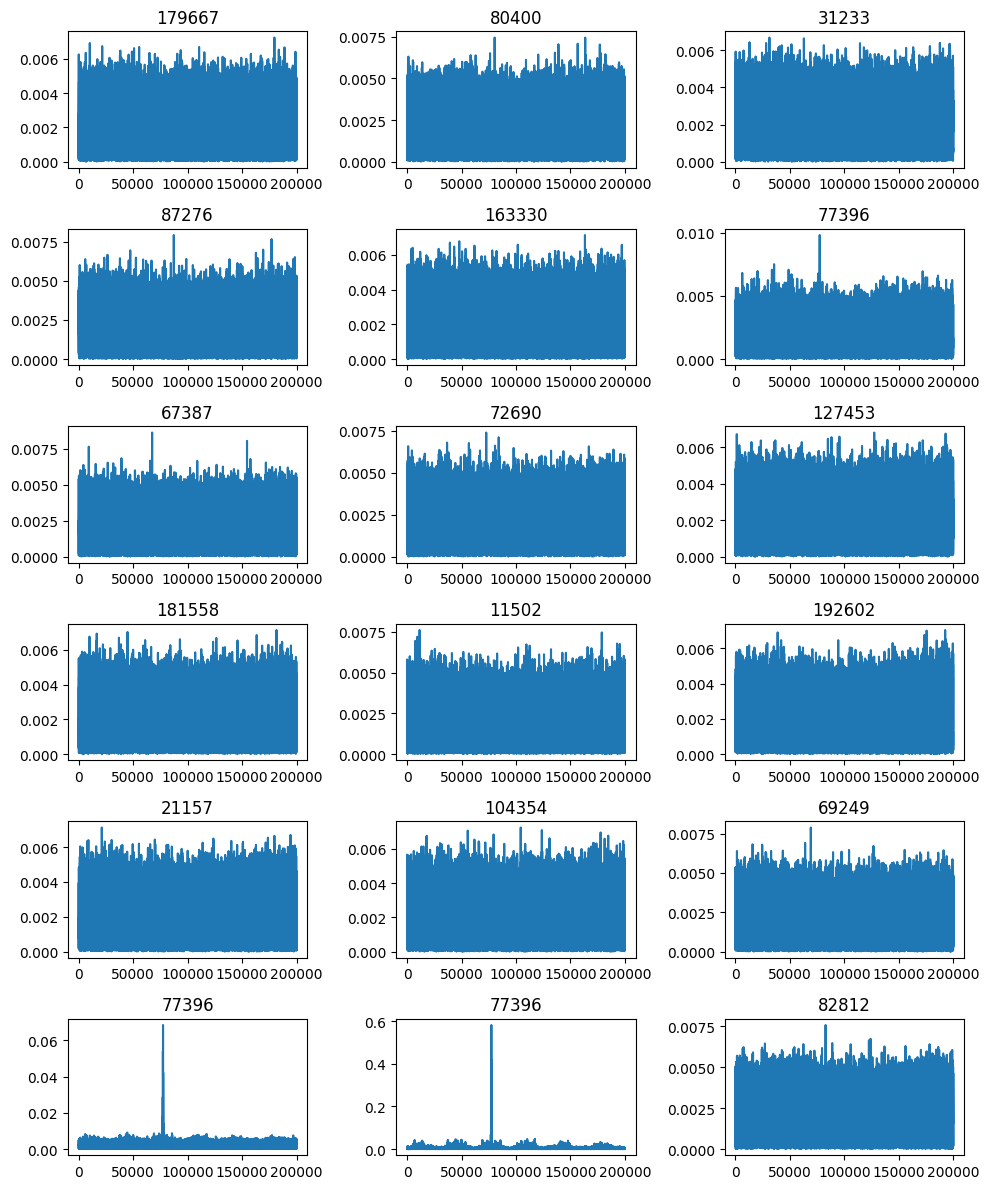

In [37]:
#CORRECTED

fig,ax=plt.subplots(6,3)
fig.set_size_inches(10,12)
ax=ax.flatten()
for cc in range(nchans):
    mm=np.argmax(np.abs(xc_corrected[cc,center-dN:center+dN]))
    ax[cc].set_title(f"{mm}")
    #ax[cc].plot(np.abs(xc_uncorrected[cc, peak_center - 200:peak_center + 200]))
    ax[cc].plot(np.abs(xc_corrected[cc,center-dN:center+dN]))
plt.tight_layout()

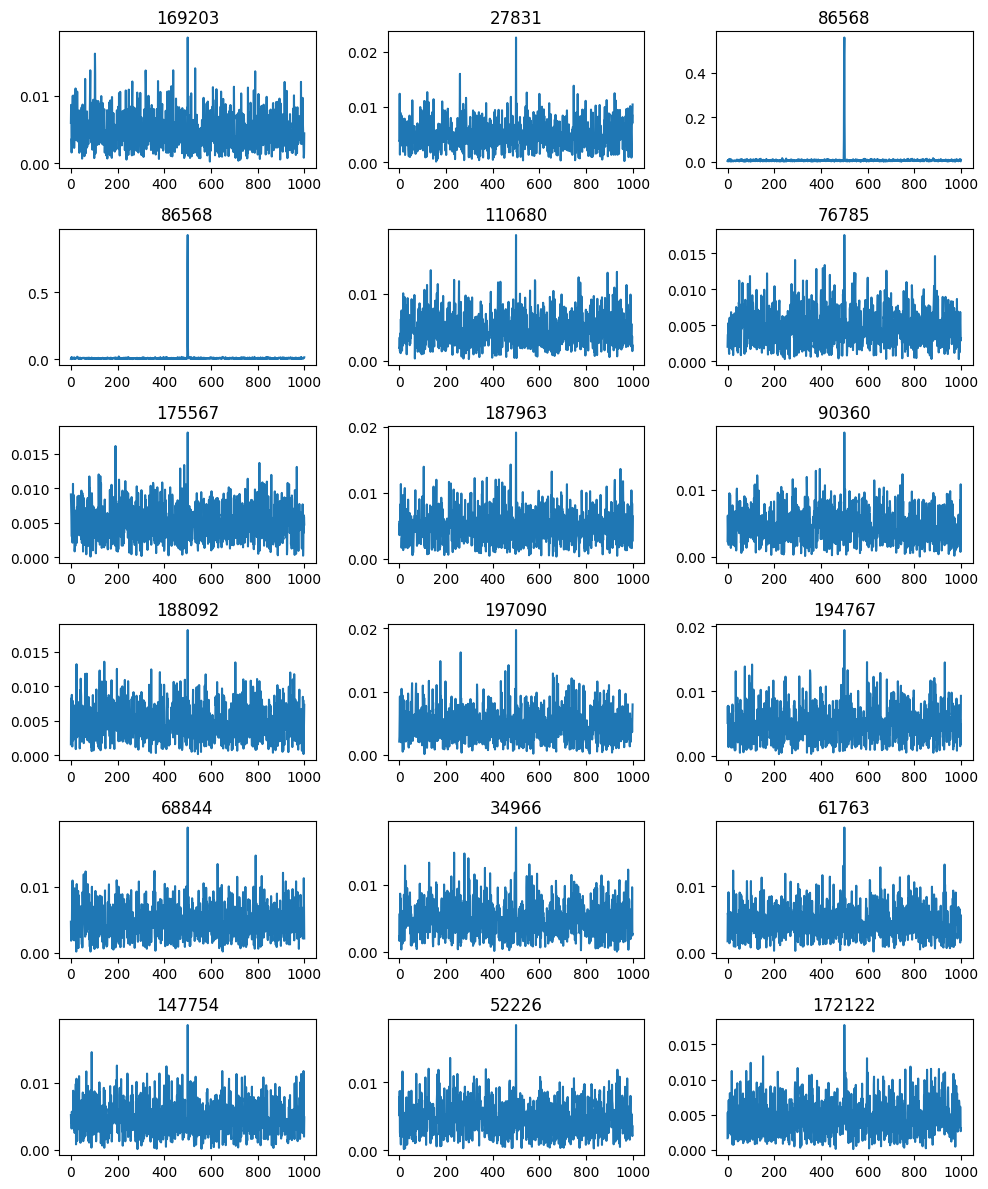

In [72]:
dN= 100000
fig,ax=plt.subplots(6,3)
fig.set_size_inches(10,12)
ax=ax.flatten()
for cc in range(nchans):
    peak_data = np.abs(xc_corrected[cc,c_acclen - dN:c_acclen + dN])
    peak_location = np.argmax(peak_data)
    ax[cc].set_title(f"{peak_location}")
    ax[cc].plot(peak_data[peak_location - 500:peak_location + 500])
plt.tight_layout()

1.1407722366315178
(array([  5,  12,  21,  30,  37,  47,  56,  63,  72,  82,  88,  98, 107,
       112, 114, 123, 132, 139, 149, 157, 165, 174, 183, 190, 200, 209,
       214, 216, 225, 235, 242, 251, 260, 267, 276, 286, 293, 301, 311,
       318, 327, 336, 343, 352, 362, 369, 378, 388, 394]), {'peak_heights': array([0.29050191, 0.28046068, 0.90427372, 0.30946061, 0.29533687,
       0.93769925, 0.31827972, 0.30904696, 0.97507267, 0.32842583,
       0.31225343, 0.99942112, 0.33502762, 0.31929191, 0.32436116,
       1.04259268, 0.3356883 , 0.33208894, 1.0383133 , 0.33354084,
       0.32429912, 1.06449967, 0.33316473, 0.33580176, 1.07505763,
       0.33917118, 0.32342102, 0.33291111, 1.05092402, 0.31754087,
       0.31640233, 0.98586432, 0.31015465, 0.31535297, 0.97206142,
       0.28956479, 0.30876472, 0.90094586, 0.27815723, 0.28697419,
       0.8703788 , 0.26358932, 0.2734755 , 0.79645883, 0.24732703,
       0.26051458, 0.76245943, 0.2256522 , 0.23349141])})


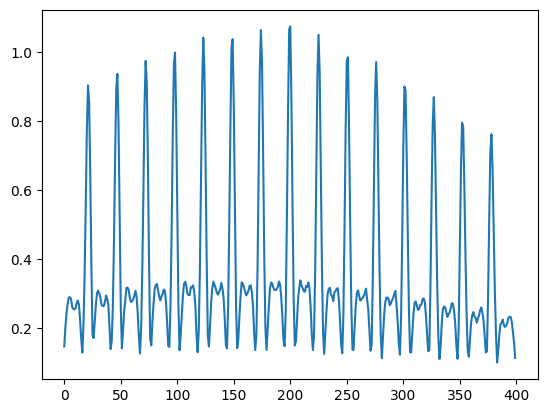

In [17]:
peak_center = c_acclen - (dN - 86568)

#get the data you want to look at
data = np.abs(xc_corrected[2][peak_center-200: peak_center+200])
plt.plot(data)

#determine the minimum prominence we want
noise_level = np.std(data)
desired_snr = 5 
min_prominence = desired_snr * noise_level
print(min_prominence)

#get our peak information

# make relative !!!!!!!
peaks_total = sn.find_peaks(data, height=0.01)
peaks_loud = sn.find_peaks(data, prominence=min_prominence)

print(peaks_total)


In [18]:
peak_location = np.argmax(data)
peak_data = data[peak_location - 200:peak_location + 200]
peaks_total = sn.find_peaks(data, height=0.001)
heights = peaks_total[1]['peak_heights']
height_indices = np.argsort(heights)

tallest = heights[height_indices[-1]]
reps, total = 4, 0
for i in range(reps):
    total += (tallest - heights[height_indices[-(i+2)]])
rel_ratio = (total/(tallest * reps))
print("\nRELIABILITY RATIO:", rel_ratio)

if rel_ratio < 0.15:
    sat_label = "UNRELIABLE"
elif rel_ratio > 0.7:
    sat_label = "RELIABLE"
else:
    sat_label = "UNCLEAR"

print("\nSTATUS:", sat_label)


RELIABILITY RATIO: 0.024161693394190966

STATUS: UNRELIABLE


<h1 style="font-size:30pt">VISIBILITY</h1>

In [34]:
idx_correction=87077-100000
if idx_correction>0:
    idx1_v = idx1 + idx_correction
    idx2_v = idx2
else:
    idx2_v = idx2 + np.abs(idx_correction)
    idx1_v = idx1
print("Corrected Starting Indices:", idx1_v, idx2_v)

Corrected Starting Indices: 305176 2027083


In [35]:
ant1_v = bdc.BasebandFileIterator(files_a1, 0, idx1_v, v_acclen, nchunks=v_nchunks, chanstart=chanstart, chanend=chanend, type='float')
ant2_v = bdc.BasebandFileIterator(files_a2, 0, idx2_v, v_acclen, nchunks=v_nchunks, chanstart=chanstart, chanend=chanend, type='float')

ACCLEN RECEIVED IS 30000
took 0.547 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721800712.raw
START SPECNUM IS 1033442694 obj start at 1033137518
ACCLEN RECEIVED IS 30000
took 0.170 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721800684.raw
START SPECNUM IS 1089685844 obj start at 1087658761


In [36]:
m1=ant1_v.spec_num_start
m2=ant2_v.spec_num_start
visibility_phased = np.zeros((v_nchunks,len(ant1_v.channel_idxs)), dtype='complex64')
st=time.time()
        
for i, (chunk1,chunk2) in enumerate(zip(ant1_v,ant2_v)):
        # pol00[i,:] = cr.avg_xcorr_4bit_2ant(chunk1['pol0'], chunk2['pol0'],chnk1['specnums'],chunk2['specnums'],m1+i*acclen,m2+i*acclen)
        xcorr = avg_xcorr_4bit_2ant_float(
                chunk1['pol0'], 
                chunk2['pol0'],
                chunk1['specnums'],
                chunk2['specnums'],
                m1+i*v_acclen,
                m2+i*v_acclen)
        visibility_phased[i,:] = np.sum(xcorr,axis=0)/v_acclen
        print("CHUNK", i, " has ", xcorr.shape[0], " rows")
print("Time taken final:", time.time()-st)
visibility_phased = np.ma.masked_invalid(visibility_phased)

CHUNK 0  has  30000  rows
CHUNK 1  has  30000  rows
CHUNK 2  has  30000  rows
CHUNK 3  has  30000  rows
CHUNK 4  has  30000  rows
CHUNK 5  has  30000  rows
CHUNK 6  has  30000  rows
CHUNK 7  has  30000  rows
CHUNK 8  has  30000  rows
CHUNK 9  has  30000  rows
CHUNK 10  has  30000  rows
CHUNK 11  has  30000  rows
CHUNK 12  has  30000  rows
CHUNK 13  has  30000  rows
CHUNK 14  has  30000  rows
CHUNK 15  has  30000  rows
CHUNK 16  has  30000  rows
CHUNK 17  has  30000  rows
CHUNK 18  has  30000  rows
CHUNK 19  has  30000  rows
CHUNK 20  has  30000  rows
CHUNK 21  has  30000  rows
took 0.177 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721800729.raw
CHUNK 22  has  30000  rows
CHUNK 23  has  30000  rows
CHUNK 24  has  30000  rows
CHUNK 25  has  30000  rows
CHUNK 26  has  30000  rows
CHUNK 27  has  30000  rows
CHUNK 28  has  30000  rows
CHUNK 29  has  30000  rows
CHUNK 30  has  30000  rows
CHUNK 31  has  30000  rows
CHUNK 32  has  30000  rows
CHUNK 33  

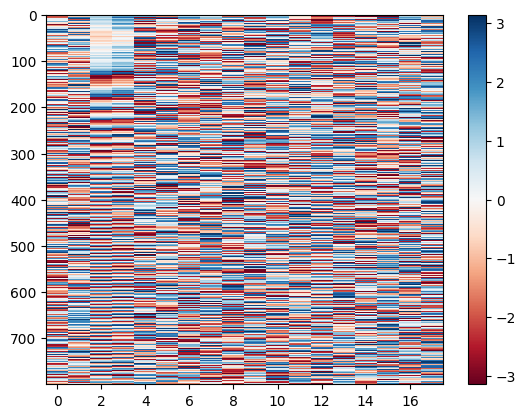

In [ ]:
isolated_time = 800

vis_phase = np.angle(visibility_phased)
# vis_phase_1clk = np.angle(visibility_1clk)
plt.imshow(vis_phase[:isolated_time,:], aspect='auto',cmap='RdBu',interpolation="none")
plt.colorbar()

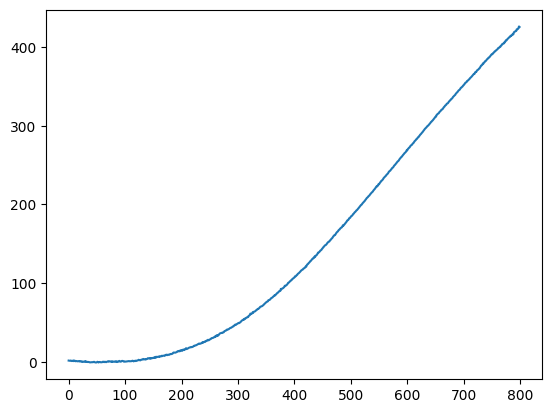

In [ ]:
plt.plot(np.unwrap(vis_phase[0:isolated_time,2]))